<a href="https://colab.research.google.com/github/i311297/Files/blob/master/turnover_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("staff_efs_to_pred.csv",sep = ";")

In [3]:
data['MONTH_DATE'] =list(map(lambda x: x + "-01",  data["MONTH_DATE"]))

## Мысли подхода к задаче

1. сначала предсказывать количество физиков
2. Зная текучку посчитать колво в индустрии
3. распределить на бины.

In [4]:
df_seva = pd.read_excel("staff_turnover.xlsx").drop(["id", "industry_name", "region_name"], axis=1)
# df_seva.month_date = pd.to_datetime(df_seva.month_date)

In [5]:
df_seva.head()

,month_date,region_id,industry_id,avg_staff_turnover
0,2017-01-01,7,15,5.00
1,2017-01-01,8,21,2.50
2,2017-01-01,4,33,3.85
3,2017-01-01,8,22,1.72
4,2017-01-01,8,11,2.89


### предсказываю колличество фл

#### сначала предскажу на основе Севы кол_во фл
1. убрать бины оставить текучку и колво фл
2. заджоинить с Севой

In [6]:
df_to_pred = data.drop(["bin_number", "count", "cnt_turnover", "inn_cnt", "percent"], axis = 1)

In [7]:
df_to_pred.columns = list(map(lambda x:x.lower(), df_to_pred.columns))

In [8]:
#джоиню с севой 
df_cnt_pred = df_seva.merge(df_to_pred,on = ["industry_id", "region_id", "month_date"], how = "left")\
               .sort_values(["industry_id", "region_id", "month_date"], ascending = False)\
            .drop("avg_staff_turnover_y", axis= 1).sort_values("month_date", ascending = True)

In [9]:
#ДЛЯ ОБУЧЕНИЯ
df = df_cnt_pred.dropna().drop_duplicates()


In [10]:
df.columns

Index(['month_date', 'region_id', 'industry_id', 'avg_staff_turnover_x',
       'cnt_fl'],
      dtype='object')

In [11]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

import itertools as it 


def block_cross_features(X, id_blocks):
    '''
        Рассчет крос признаков между блоками признаков.
    '''
    # создание пар id признаков
    cross_pairs = []
    for b1, b2 in it.combinations(id_blocks, 2):
        cross_pairs.extend(list(it.product(b1, b2)))
    
    # рассчет крос признаков 
    X_new = np.zeros((X.shape[0], len(cross_pairs)))
    for i, id_pair in enumerate(cross_pairs):
        X_new[:,i] = X[:,id_pair].prod(axis=1)
        
    return X_new

def creare_featuers(X, oh_enc):
    '''
        Подготовка призаков для модели.
    '''
    
    # onehot для месяца, региона и отрасти
    X_onehot = oh_enc.transform(X[:,:3])
    X_year = X[:,-1:]
    
    # группы id признаков
    id_blocks = [
        np.arange(len(oh_enc.categories_[0])-1),
        np.arange(len(oh_enc.categories_[1])-1) + len(oh_enc.categories_[0])-1,
        np.arange(len(oh_enc.categories_[2])-1) + len(oh_enc.categories_[1])-1 + len(oh_enc.categories_[0])-1,
    ]
    
    # крос признаки между дамми переменными
    X_cross = block_cross_features(X_onehot.toarray(), id_blocks)
    
    # итоговые признаки
    X = np.concatenate([
        np.ones((X_onehot.shape[0], 1)), # constant 
        X_cross, # dummy cross featuers
        X_onehot.toarray(), # dummy features
        X_year
    ], axis=1)
    
    # проверка
    n_month = 12
    n_region = df["region_id"].unique().shape[0]
    n_industry = df["industry_id"].unique().shape[0]
    n_year_feature = 1
    
    n_features = ((n_month-1)*(n_industry-1) + (n_region-1)*(n_month-1) + (n_region-1)*(n_industry-1)) + \
                 ((n_month-1)+(n_industry-1)+(n_region-1)) + n_year_feature + 1
    
    assert X.shape[1] == n_features
    
    return X

In [19]:
oh_enc = OneHotEncoder(drop = "first")



df["month_date"] = pd.to_datetime(df["month_date"])
df["month"] = df["month_date"].dt.month
df["year"] = df["month_date"].dt.year
X = df[["region_id", "industry_id", "month", "year"]].values
y = df["cnt_fl"].values

oh_enc.fit(X[:,:3])

X = creare_featuers(X, oh_enc)
X.shape, y.shape

((13686, 1180), (13686,))

In [20]:
# train test split
X_test = X[X[:,-1]==2019]
y_test = y[X[:,-1]==2019]

X_train = X[X[:,-1]!=2019]
y_train = y[X[:,-1]!=2019]

X_train.shape, X_test.shape

((9445, 1180), (4241, 1180))

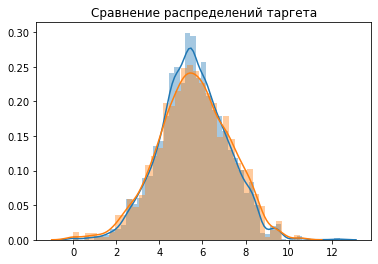

In [23]:
sns.distplot((np.log(y_train)))
sns.distplot((np.log(y_test)))
plt.title("Сравнение распределений таргета");

### Обучение модели


In [26]:
from rvl import RVL

In [30]:
model = RVL(max_iter=5000)
model.fit(X_train, np.log(y_train))

100%|██████████| 5000/5000 [07:23<00:00, 11.29it/s]


In [28]:
def get_scores(y, y_pred):
    '''
        Оценка качества предстказаний модели.
    '''
    rmse = np.sqrt(((y-y_pred)**2).mean())
    mae = np.abs(y-y_pred).mean()
    mape = np.abs((y-y_pred)/y_pred).mean()
    return rmse, mae, mape

In [31]:
print((model.w != 0).sum())

y_pred = model.predict(X_train)
y_pred = np.exp(y_pred)
print("train: RMSE: {:.5}, MAE: {:.5}, MAPE: {:.5}".format(*get_scores(y_train, y_pred)))

y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
print("test:  RMSE: {:.5}, MAE: {:.5}, MAPE: {:.5}".format(*get_scores(y_test, y_pred)))

595
train: RMSE: 4662.6, MAE: 266.07, MAPE: 0.19296
test:  RMSE: 1951.3, MAE: 354.48, MAPE: 1.3956e+20


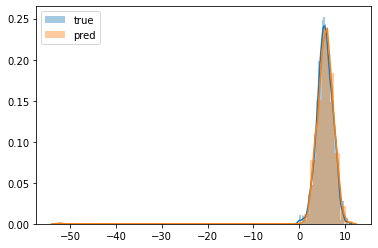

In [32]:
sns.distplot(np.log(y_test), label="true")
sns.distplot(np.log(y_pred), label="pred")
plt.legend();

In [33]:
model = RVL(max_iter=1000)
model.fit(X, np.log(y))

100%|██████████| 1000/1000 [02:02<00:00,  8.15it/s]


In [44]:
# датасет для предсказаний
dates = df["month_date"]
dates = pd.to_datetime(dates, format="%Y/%m/%d")
dates = dates[(dates > "2018.09.01")]
dates = dates[(dates <= "2019.06.01")]

dates = dates + pd.DateOffset(years=1)

In [45]:
u_reg_id = df["region_id"].unique()
u_ind_id = df["industry_id"].unique()
u_date = dates.unique()

pred_df = pd.DataFrame(
    data = list(it.product(u_date, u_reg_id, u_ind_id)),
    columns = ["month_date", "region_id", "industry_id"])

pred_df["month"] = pred_df["month_date"].dt.month
pred_df["year"] = pred_df["month_date"].dt.year

In [46]:
X = pred_df[["region_id", "industry_id", "month", "year"]].values

X_future = creare_featuers(X, oh_enc)
X_future.shape

(4968, 1180)

In [47]:
pred = np.exp(model.predict(X_future))

In [48]:
pred[pred < 0] = 0

In [49]:
pred = list(map(round, pred))

In [50]:
pred_df.loc[:,"cnt_fl"] = pred

In [51]:
pred_df

,month_date,region_id,industry_id,month,year,cnt_fl
0,2019-10-01,8,30,10,2019,5115.0
1,2019-10-01,8,14,10,2019,1834.0
2,2019-10-01,8,19,10,2019,1720.0
3,2019-10-01,8,45,10,2019,19786.0
4,2019-10-01,8,25,10,2019,6711.0
...,...,...,...,...,...,...
4963,2020-06-01,5,29,6,2020,57.0
4964,2020-06-01,5,5,6,2020,5.0
4965,2020-06-01,5,42,6,2020,22.0
4966,2020-06-01,5,34,6,2020,3.0


In [53]:
df

,month_date,region_id,industry_id,avg_staff_turnover_x,cnt_fl,month,year
57,2017-01-01,8,30,1.610000,2109.0,1,2017
114,2017-01-01,4,14,4.880000,41.0,1,2017
68,2017-01-01,3,30,2.570000,756.0,1,2017
31,2017-01-01,4,19,16.670000,12.0,1,2017
98,2017-01-01,8,45,2.960000,11576.0,1,2017
...,...,...,...,...,...,...,...
53682,2019-09-01,4,8,5.764104,85.0,9,2019
52622,2019-09-01,10,15,5.138004,138.0,9,2019
52343,2019-09-01,5,10,13.040787,14.0,9,2019
52329,2019-09-01,5,42,6.554886,16.0,9,2019


In [58]:
df_cnt_pred

,month_date,region_id,industry_id,avg_staff_turnover_x,cnt_fl
57,2017-01-01,8,30,1.610000,2109.0
114,2017-01-01,4,14,4.880000,41.0
68,2017-01-01,3,30,2.570000,756.0
31,2017-01-01,4,19,16.670000,12.0
98,2017-01-01,8,45,2.960000,11576.0
...,...,...,...,...,...
58465,2020-05-01,7,40,4.639509,NaN
58532,2020-05-01,4,23,11.162620,NaN
58170,2020-05-01,12,43,13.085023,NaN
58174,2020-05-01,12,37,14.605193,NaN


In [62]:
df_cnt_pred.month_date = df_cnt_pred.month_date.apply(pd.to_datetime)

In [82]:
res = df_cnt_pred.merge(pred_df, on = ["month_date", "region_id", "industry_id"], how = "outer")

In [83]:
res.cnt_fl_x = res.cnt_fl_x.fillna(value = res.cnt_fl_y)

In [84]:
res = res.drop(["month", "year", "cnt_fl_y"], axis = 1).rename(columns = {"cnt_fl_x": "cnt_fl", "avg_staff_turnover_x" : "avg_staff_turnover"})

In [85]:
res

,month_date,region_id,industry_id,avg_staff_turnover,cnt_fl
0,2017-01-01,8,30,1.61,2109.0
1,2017-01-01,8,30,1.61,2109.0
2,2017-01-01,8,30,1.61,2109.0
3,2017-01-01,8,30,1.61,2109.0
4,2017-01-01,8,30,1.61,2109.0
...,...,...,...,...,...
59199,2020-06-01,5,29,NaN,57.0
59200,2020-06-01,5,5,NaN,5.0
59201,2020-06-01,5,42,NaN,22.0
59202,2020-06-01,5,34,NaN,3.0


In [81]:
res.to_csv("res.csv", sep = ";")

Пердсказание последнего месяца текучки

In [97]:
df = res[res.month_date <= "2020-05-01"]
df["month_date"] = pd.to_datetime(df["month_date"])
df["month"] = df["month_date"].dt.month
df["year"] = df["month_date"].dt.year
X = df[["region_id", "industry_id", "month", "year"]].values
y = df["avg_staff_turnover"].values

oh_enc.fit(X[:,:3])

X = creare_featuers(X, oh_enc)
X.shape, y.shape

((58652, 1180), (58652,))

In [98]:
model.fit(X, np.log(y))

100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]


In [99]:
# датасет для предсказаний
dates = df["month_date"]
dates = pd.to_datetime(dates, format="%Y/%m/%d")
dates = dates[(dates > "2019.05.01")]
dates = dates[(dates <= "2019.06.01")]

dates = dates + pd.DateOffset(years=1)

In [100]:
u_reg_id = df["region_id"].unique()
u_ind_id = df["industry_id"].unique()
u_date = dates.unique()

pred_df = pd.DataFrame(
    data = list(it.product(u_date, u_reg_id, u_ind_id)),
    columns = ["month_date", "region_id", "industry_id"])

pred_df["month"] = pred_df["month_date"].dt.month
pred_df["year"] = pred_df["month_date"].dt.year

In [101]:
X = pred_df[["region_id", "industry_id", "month", "year"]].values

X_future = creare_featuers(X, oh_enc)
X_future.shape

(552, 1180)

In [102]:
pred = np.exp(model.predict(X_future))
pred[pred < 0] = 0

In [103]:
pred

array([ 4.54060421,  4.36849554,  5.01646691,  6.83206183,  5.03415296,
        6.01772514,  3.58723716,  6.91071811,  4.72457845, 15.16519829,
        4.58201013,  6.59840321,  4.05985621,  6.5227588 ,  7.16352835,
        5.27018055,  4.44194758,  4.72457845,  5.40204221,  4.5157924 ,
        5.67639608,  4.59393292,  5.26858231,  9.78171847,  3.56135512,
        7.0256609 ,  3.66670043,  5.62296658,  6.54540439,  2.31040237,
        6.84231993, 13.35595147,  5.33184469,  6.04196942,  4.05973736,
        4.72457845, 11.09551323,  4.30219652,  6.70353239,  5.10905197,
        4.90891171,  6.22675323,  3.72925451,  4.6627498 , 10.42371328,
       12.98224742,  4.73068832,  4.7774702 ,  6.55244577,  8.43546977,
        5.63947515,  5.13434202,  3.33239348,  7.86706069,  5.16688928,
       16.58495064,  5.78226732,  6.68523242,  4.43993633,  6.60460226,
        6.90917053,  7.83017035,  4.03247523,  5.16688928,  7.78585318,
        4.31053508,  6.44172943,  7.63036316, 11.51244956, 13.77

In [104]:
pred_df.loc[:,"avg_staff_turnover"] = pred

In [106]:
pred_df.avg_staff_turnover = list(map(lambda x: round(x, 2), pred_df.avg_staff_turnover))

In [107]:
pred_df

,month_date,region_id,industry_id,month,year,avg_staff_turnover
0,2020-06-01,8,30,6,2020,4.54
1,2020-06-01,8,14,6,2020,4.37
2,2020-06-01,8,19,6,2020,5.02
3,2020-06-01,8,45,6,2020,6.83
4,2020-06-01,8,25,6,2020,5.03
...,...,...,...,...,...,...
547,2020-06-01,5,29,6,2020,9.47
548,2020-06-01,5,5,6,2020,14.95
549,2020-06-01,5,42,6,2020,8.15
550,2020-06-01,5,34,6,2020,6.25


In [118]:
result = pred_df.merge(res, on = ["month_date", "region_id", "industry_id"], how = "outer")
       

In [120]:
result.avg_staff_turnover_x = result.avg_staff_turnover_x.fillna(value= result.avg_staff_turnover_y)

In [124]:
result.drop(["month", "year", "avg_staff_turnover_y"], axis = 1).rename(columns = {"avg_staff_turnover_x" : "avg_staff_turnover"}).to_csv("result.csv", sep = ";")

In [ ]:
result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')